In [13]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

In [14]:
ds_hotel = pd.read_csv('hotel.csv')
ds_reviews = pd.read_csv('reviews.csv')
ds_wb = pd.read_csv('wildberries.csv')
ds_women = pd.read_csv('women.csv', lineterminator='\n')
ds_phone = pd.read_csv('phone.csv')

dataset = pd.concat([ds_hotel, ds_reviews, ds_wb, ds_phone, ds_women], join='outer')
dataset = dataset.dropna() # Были замечены строчки с nan
dataset = dataset.reset_index(drop=True)
dataset = dataset.drop(columns=['id'], axis = 1)

### **№1**
**Считаем полную частоту каждого слова в датасете**

In [15]:
for i in 'аяАЯёЁ ':
  print(i, ord(i))

а 1072
я 1103
А 1040
Я 1071
ё 1105
Ё 1025
  32


In [16]:
def text_ru_clear(txt : str) -> str:
  # Оставить в тексте только словообразующие символы
  for letter in txt:
    x = ord(letter)
    if (x >= 1072 and x <= 1103) or (x >= 1040 and x <= 1071) or x == 1105 or x == 1025 or x == 32:
      continue
    else:
      txt = txt.replace(letter, '')
  while '  ' in txt:
    txt = txt.replace('  ', ' ')
  return txt 

In [17]:
texts = dataset._get_column_array(0)
labels = dataset._get_column_array(1)

In [18]:
# Стандартизация текстов отзывов и приведение к виду списка

with tqdm.trange(len(dataset)) as t:
  for i in t:
    texts[i] = text_ru_clear(texts[i])
    texts[i] = texts[i].split(' ')
    for j in range(len(texts[i])):
      texts[i][j] = texts[i][j].lower()

100%|██████████| 808171/808171 [01:35<00:00, 8427.36it/s] 


In [19]:
# Подсчет частоты
F_true = {}
Q_true = {}

with tqdm.trange(len(dataset)) as t:
  for i in t:
    for word in texts[i]:
      count = F_true.get(word,0)
      F_true[word] = count + 1
      Q_true[word] = count + 1
     
frequency_list = F_true.keys()

100%|██████████| 808171/808171 [00:34<00:00, 23693.57it/s]


In [20]:
# Приведем к частоте, разделив на общее число слов в датасете
for word in frequency_list:
  F_true[word] = F_true[word]/len(dataset)

In [21]:
WF = pd.DataFrame([[word, F_true[word]] for word in frequency_list], columns=['word', 'F_true'])

In [22]:
print(WF)

                      word    F_true
0                    очень  0.403794
1                достойный  0.009960
2                    отель  0.064398
3                        с  0.515094
4              прекрасными  0.000196
...                    ...       ...
630637      цветовпродавца  0.000001
630638   идеальнонасколько  0.000001
630639         блузкесшита  0.000001
630640  справитсяразмерная  0.000001
630641              провдо  0.000001

[630642 rows x 2 columns]


In [23]:
print(WF.sort_values(by='F_true', ascending=False))

                     word    F_true
10                      и  1.338521
16                     не  1.254876
36                      в  1.162927
13                     на  0.834808
3                       с  0.515094
...                   ...       ...
143103       москвепервый  0.000001
422000         понялазвук  0.000001
143104            стмвднх  0.000001
143105  выборценакачество  0.000001
630641             провдо  0.000001

[630642 rows x 2 columns]


### **№2**
**Считаем частоту каждого слова в отрицательной части датасета**

In [24]:
dataset_negative = dataset[dataset['label'].isin([-1])]
dataset_negative = dataset_negative.reset_index(drop=True)

In [25]:
texts_n = dataset_negative._get_column_array(0)

In [26]:
F_negative = {}
Q_negative = {}

for i in range(len(dataset)):
  for word in texts[i]:
    F_negative[word] = 0
    Q_negative[word] = 0
for i in range(len(dataset_negative)):
  for word in texts_n[i]:
    count = F_negative.get(word, 0)
    F_negative[word] = count + 1
    Q_negative[word] = count + 1

frequency_list = F_true.keys()

In [27]:
for word in frequency_list:
  F_negative[word] = F_negative[word]/len(dataset_negative)

In [28]:
WF_n = pd.DataFrame([[word, F_negative[word]] for word in frequency_list], columns=['word', 'F_negative'])

In [29]:
print(WF_n)

                      word  F_negative
0                    очень    0.299459
1                достойный    0.003290
2                    отель    0.049955
3                        с    0.583545
4              прекрасными    0.000100
...                    ...         ...
630637      цветовпродавца    0.000000
630638   идеальнонасколько    0.000000
630639         блузкесшита    0.000000
630640  справитсяразмерная    0.000000
630641              провдо    0.000000

[630642 rows x 2 columns]


In [30]:
print(WF_n.sort_values(by='F_negative', ascending=False))

                        word  F_negative
16                        не    1.710583
10                         и    1.457353
36                         в    1.313310
13                        на    0.940241
3                          с    0.583545
...                      ...         ...
325059           следующеена    0.000000
325058  предыдущемпорадовало    0.000000
325057             личнохотя    0.000000
325056          кассыбыстрый    0.000000
630641                провдо    0.000000

[630642 rows x 2 columns]


In [31]:
# датафрейм с частотами
main_df = pd.DataFrame([[word, F_true[word], F_negative[word], F_negative[word]/F_true[word]] for word in frequency_list], columns=['word', 'F_true', 'F_negative', 'power_n'])
main_df = main_df[main_df.F_true > 0.0001]
main_df = main_df.reset_index(drop=True)

In [32]:
# датафрейм с количествами
Q_df = pd.DataFrame([[word, Q_true[word], Q_negative[word], Q_negative[word]/Q_true[word]] for word in frequency_list], columns=['word', 'Q_true', 'Q_negative', 'power_n'])
Q_df = Q_df[Q_df.Q_true > 2000]
Q_df = Q_df.reset_index(drop=True)

In [33]:
print(len(main_df))
print(main_df.sort_values(by='power_n', ascending=False)[0:40])

20730
                 word    F_true  F_negative   power_n
20725        обманщик  0.000244    0.001078  4.423540
18370        мошенник  0.000111    0.000492  4.419255
17930            сдаю  0.000151    0.000652  4.322388
20324         свяжусь  0.000101    0.000431  4.250914
15905          кормил  0.000165    0.000691  4.200103
17139           врагу  0.000207    0.000863  4.174550
14928    связывайтесь  0.000161    0.000647  4.022019
19135       выкинутые  0.000156    0.000625  4.007832
8786         отказано  0.000214    0.000846  3.952273
20243     независимую  0.000127    0.000503  3.948260
17670     выброшенные  0.000455    0.001797  3.946727
16103      поберегите  0.000126    0.000498  3.943155
14449          дерьмо  0.000142    0.000558  3.924868
15895        прождала  0.000212    0.000829  3.920096
11415       выброшены  0.000130    0.000509  3.915616
14730      обещаниями  0.000125    0.000487  3.893703
17040          выкину  0.000158    0.000614  3.875382
18349      экспертиза 

In [34]:
print(len(Q_df))
print(Q_df.sort_values(by='power_n', ascending=False)[0:40])

1890
               word  Q_true  Q_negative   power_n
1255         никому    3291        2706  0.822242
1629           спор    5502        4483  0.814795
545         ужасный    3345        2622  0.783857
1610        открыла    2428        1878  0.773476
1433  разочарование    2739        2107  0.769259
1693   разочарована    2086        1589  0.761745
752     разочарован    3406        2538  0.745156
1806      сервисный    2059        1507  0.731909
505            ужас    3449        2512  0.728327
1345        вернуть    3795        2742  0.722530
973         вернули    8035        5803  0.722215
1680           сдал    2981        2111  0.708152
1448       начались    2163        1490  0.688858
1263         ужасно    4491        2978  0.663104
922          полное    2289        1493  0.652250
1858             сц    2017        1302  0.645513
1619         вернул    3449        2226  0.645404
1621        сервисе    2297        1478  0.643448
1708         товара    2139        1358  0.63

### **№4**
Обучаем модель


In [35]:
# Блоки данных для обучения (основаны на датафрейме с количествами)
train_set = pd.DataFrame([[Q_df['Q_negative'][i]] for i in range(len(Q_df))], columns=['Q_negative'])
target = pd.DataFrame([Q_df['Q_true'][i] for i in range(len(Q_df))], columns=['Q_true'])
test_set = [[Q_negative[word]] for word in frequency_list] # полный по содержанию датасет
target_test = pd.DataFrame([Q_true[word] for word in frequency_list], columns=['Q_true'])
# ЗАМЕНЯЕТ РЕЗУЛЬТАТЫ БЛОКА НИЖЕ!
# ВСЕ РЕЗУЛЬТАТЫ ПОЛУЧЕНЫ НА НИЖНЕМ БЛОКЕ

In [36]:
# Блоки данных для обучения (основаны на датафрейме с частотами)
train_set = pd.DataFrame([[main_df['F_negative'][i]] for i in range(len(main_df))], columns=['F_negative'])
target = pd.DataFrame([main_df['F_true'][i] for i in range(len(main_df))], columns=['F_true'])
test_set = pd.DataFrame([[F_negative[word]] for word in frequency_list], columns=['F_negative']) # полный по содержанию датасет
target_test = pd.DataFrame([F_true[word] for word in frequency_list], columns=['F_true'])

In [37]:
#train_set = pd.DataFrame([F_negative[word] for word in frequency_list], columns=['F_negative'])

In [38]:
#target = pd.DataFrame([F_true[word] for word in frequency_list], columns=['F_true'])
#scaler = StandardScaler()
#scaler.fit(tr) 
#scaled_df = scaler.transform(food)

In [39]:
#scaled_df = [[F_negative[word]] for word in frequency_list]

In [40]:
# блок инициализации и обучения модели 
linear_regression_model = SGDRegressor(tol=0.00001, eta0=1.2)
linear_regression_model.fit(train_set, target)
predictions = linear_regression_model.predict(test_set)
mse = mean_squared_error(target_test, predictions) 
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.0009116639044502834


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
'''word = input()
prediction = linear_regression_model.predict([[F_negative[word]]])
print('prediction:', prediction, 'reallity:', F_true[word])
print(prediction - F_true[word])

print('true:', F_negative[word]/F_true[word], 'prediction:', F_negative[word]/prediction)'''

"word = input()\nprediction = linear_regression_model.predict([[F_negative[word]]])\nprint('prediction:', prediction, 'reallity:', F_true[word])\nprint(prediction - F_true[word])\n\nprint('true:', F_negative[word]/F_true[word], 'prediction:', F_negative[word]/prediction)"

In [42]:
'''word = input()
prediction = linear_regression_model.predict([[Q_negative[word]]])
print('prediction:', prediction, 'reallity:', Q_true[word])
print(prediction - Q_true[word])

print('true:', Q_negative[word]/Q_true[word], 'prediction:', Q_negative[word]/prediction)
# ИСПОЛЬЗУЕТСЯ ПРИ ОБУЧЕНИИ НА КОЛИЧЕСТВЕННЫХ ДАННЫХ
# КОЛИЧЕСТВЕННЫЕ ДАННЫЕ ПОКАЗАЛИ СЕБЯ ПЛОХО'''

"word = input()\nprediction = linear_regression_model.predict([[Q_negative[word]]])\nprint('prediction:', prediction, 'reallity:', Q_true[word])\nprint(prediction - Q_true[word])\n\nprint('true:', Q_negative[word]/Q_true[word], 'prediction:', Q_negative[word]/prediction)\n# ИСПОЛЬЗУЕТСЯ ПРИ ОБУЧЕНИИ НА КОЛИЧЕСТВЕННЫХ ДАННЫХ\n# КОЛИЧЕСТВЕННЫЕ ДАННЫЕ ПОКАЗАЛИ СЕБЯ ПЛОХО"

1) Привести датасет к целочисленным характеристикам (не к частоте, а к количеству)

2) Обучить модель на обновленном датасете

3) Создать столбец F_pred(w) - F_True(w)

4) Проанализировать результаты

5) Сделать тоже самое для положительеной части датасета

6) Получить полный результат в виде csv-файла (word, F_true, F_negative, pred_n 
power_n, F_positive, power_p, pred_p)


[0.7217323] [0.00058981]


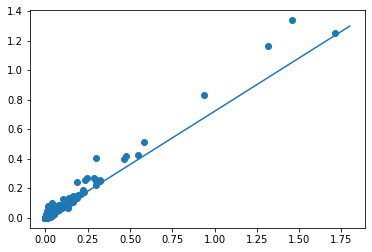

In [43]:
coef = linear_regression_model.coef_
bias = linear_regression_model.intercept_
plt.scatter(main_df['F_negative'], main_df['F_true']);
x = [i/1000 for i in range(1800)]
plt.plot(x, [bias + coef * l for l in x]);
print(coef, bias)

### **№5**

**Собираем датафрейм с предсказанной оценкой**

In [48]:
predicitons_negative = linear_regression_model.predict(pd.DataFrame([[F_negative[word]] for word in frequency_list], columns=['F_negative']))
i = 0
for word in frequency_list:
  predicitons_negative[i] = predicitons_negative[i] - F_true[word]
  i += 1

In [50]:
main_df = pd.DataFrame([[word, F_true[word], F_negative[word], F_negative[word]/F_true[word]] for word in frequency_list], columns=['word', 'F_true', 'F_negative', 'power_n'])
main_df = main_df.join(pd.DataFrame([predicitons_negative[i] for i in range(len(main_df))], columns=['pred_n']))
#main_df = main_df[main_df.F_true > 0.0001]
#main_df = main_df.reset_index(drop=True)
print(main_df)

                      word    F_true  F_negative   power_n    pred_n
0                    очень  0.403794    0.299459  0.741612 -0.187076
1                достойный  0.009960    0.003290  0.330352 -0.006995
2                    отель  0.064398    0.049955  0.775716 -0.027755
3                        с  0.515094    0.583545  1.132890 -0.093341
4              прекрасными  0.000196    0.000100  0.509116  0.000466
...                    ...       ...         ...       ...       ...
630637      цветовпродавца  0.000001    0.000000  0.000000  0.000589
630638   идеальнонасколько  0.000001    0.000000  0.000000  0.000589
630639         блузкесшита  0.000001    0.000000  0.000000  0.000589
630640  справитсяразмерная  0.000001    0.000000  0.000000  0.000589
630641              провдо  0.000001    0.000000  0.000000  0.000589

[630642 rows x 5 columns]


In [51]:
# Действельно, характеристика pred_n показывает степень негативности слова
print(main_df.sort_values(by='pred_n', ascending=False)[:20])

             word    F_true  F_negative   power_n    pred_n
182         через  0.070605    0.130987  1.855199  0.024522
3898      вернули  0.009942    0.032089  3.227515  0.013807
94520    продавец  0.015640    0.038298  2.448708  0.012591
31064        спор  0.006808    0.024789  3.641243  0.011673
132        деньги  0.077343    0.121592  1.572119  0.011004
15830      месяца  0.026720    0.051354  1.921958  0.010934
2369       ремонт  0.011309    0.029528  2.610938  0.010592
52387    гарантии  0.008842    0.024994  2.826682  0.009787
1871     покупать  0.028393    0.051371  1.809299  0.009273
2959   невозможно  0.009324    0.024568  2.635085  0.008998
1600        потом  0.030100    0.053134  1.765262  0.008839
1250        после  0.098332    0.147310  1.498090  0.008576
31535       начал  0.011686    0.026714  2.286034  0.008184
30173    перестал  0.008144    0.021234  2.607203  0.007771
1218      сказали  0.006648    0.018718  2.815421  0.007451
8106       никому  0.004072    0.014963 

### **№6**
**Сделаем тоже самое с позитивной частью датасета**

In [53]:
dataset_positive = dataset[dataset['label'].isin([1])]
dataset_positive = dataset_positive.reset_index(drop=True)

In [54]:
texts_p = dataset_positive._get_column_array(0)

In [55]:
F_positive = {}
Q_positive = {}

for i in range(len(dataset)):
  for word in texts[i]:
    F_positive[word] = 0
    Q_positive[word] = 0
for i in range(len(dataset_positive)):
  for word in texts_p[i]:
    count = F_positive.get(word, 0)
    F_positive[word] = count + 1
    Q_positive[word] = count + 1

frequency_list = F_true.keys()

In [56]:
for word in frequency_list:
  F_positive[word] = F_positive[word]/len(dataset_positive)

In [57]:
positive_df = pd.DataFrame([[word,F_true[word] , F_positive[word], F_positive[word]/F_true[word]] for word in frequency_list], columns=['word', 'F_true', 'F_positive', 'power_p'])
positive_df = positive_df[positive_df.F_true > 0.001]
positive_df = positive_df.reset_index(drop=True)

In [58]:
print(len(positive_df))
print(positive_df.sort_values(by='power_p', ascending=True)[10:40])

4136
                word    F_true  F_positive   power_p
2484  отвратительный  0.001534    0.000255  0.166263
2406   отвратительно  0.001122    0.000188  0.167080
3350      возвращать  0.001595    0.000268  0.168145
2175          никому  0.004072    0.000785  0.192756
2918          кошмар  0.001080    0.000218  0.201845
686             ужас  0.004268    0.000885  0.207427
1915         ужасная  0.002471    0.000519  0.210006
3248          вернул  0.004268    0.000927  0.217134
2610           нервы  0.001991    0.000436  0.219031
3474         сдавать  0.002230    0.000512  0.229798
2436         вернуть  0.004696    0.001097  0.233555
1086     разочарован  0.004214    0.001003  0.237983
2528           сдать  0.002085    0.000499  0.239479
4128       сервисном  0.001378    0.000331  0.240431
3832       сервисный  0.002548    0.000617  0.242193
3412            сдал  0.003689    0.000903  0.244721
2193          ужасно  0.005557    0.001424  0.256214
3557     гарантийный  0.001959    0.00052

In [59]:
main_df = pd.DataFrame([[word, F_true[word], F_negative[word], F_negative[word]/F_true[word], F_positive[word], F_positive[word]/F_true[word]] for word in frequency_list], columns=['word', 'F_true', 'F_negative', 'power_n', 'F_positive', 'power_p'])
main_df = main_df.join(pd.DataFrame([predicitons_negative[i] for i in range(len(main_df))], columns=['pred_n']))

In [60]:
train_set = pd.DataFrame([[positive_df['F_positive'][i]] for i in range(len(positive_df))], columns=['F_positive'])
target = pd.DataFrame([positive_df['F_true'][i] for i in range(len(positive_df))], columns=['F_true'])
test_set = pd.DataFrame([[F_positive[word]] for word in frequency_list], columns=['F_positive']) # полный по содержанию датасет
target_test = pd.DataFrame([F_true[word] for word in frequency_list], columns=['F_true'])

In [61]:
linear_regression_model = SGDRegressor(tol=0.00001, eta0=10)
linear_regression_model.fit(train_set, target)
predictions = linear_regression_model.predict(test_set)
mse = mean_squared_error(target_test, predictions) 
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.0011376430709639305


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1.04688078] [0.00107609]


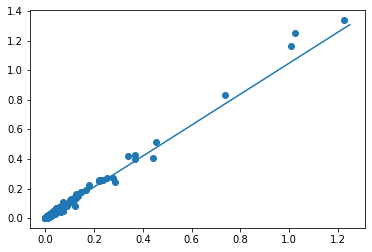

In [62]:
coef = linear_regression_model.coef_
bias = linear_regression_model.intercept_
plt.scatter(positive_df['F_positive'], positive_df['F_true']);
x = [i/1000 for i in range(1250)]
plt.plot(x, [bias + coef * l for l in x]);
print(coef, bias)

In [63]:
predicitons_positive = linear_regression_model.predict(pd.DataFrame([[F_positive[word]] for word in frequency_list], columns=['F_positive']))
i = 0
for word in frequency_list:
  predicitons_positive[i] = predicitons_positive[i] - F_true[word]
  i += 1

In [64]:
main_df = main_df.join(pd.DataFrame([predicitons_positive[i] for i in range(len(main_df))], columns=['pred_p']))
#main_df = main_df[main_df.F_true > 0.001]
#main_df = main_df.reset_index(drop=True)

In [65]:
print(len(main_df))
print(main_df.sort_values(by='pred_n', ascending=False)[10:40])

630642
                word    F_true  F_negative   power_n  F_positive   power_p  \
1600           потом  0.030100    0.053134  1.765262    0.020792  0.690761   
1250           после  0.098332    0.147310  1.498090    0.075864  0.771505   
31535          начал  0.011686    0.026714  2.286034    0.006146  0.525983   
30173       перестал  0.008144    0.021234  2.607203    0.003469  0.425936   
1218         сказали  0.006648    0.018718  2.815421    0.002220  0.333859   
8106          никому  0.004072    0.014963  3.674527    0.000785  0.192756   
2005         обратно  0.008128    0.020537  2.526645    0.003554  0.437241   
452               бы  0.110880    0.162815  1.468392    0.073683  0.664531   
619        постоянно  0.025288    0.044143  1.745623    0.017770  0.702705   
8529         месяцев  0.019080    0.035235  1.846686    0.013058  0.684388   
8285          ужасно  0.005557    0.016467  2.963352    0.001424  0.256214   
1350         ужасный  0.004139    0.014499  3.502984    0

In [72]:
main_df = main_df[main_df.F_true > 0.00001]
main_df = main_df.reset_index(drop=True)
print(main_df)

                word    F_true  F_negative   power_n  F_positive   power_p  \
0              очень  0.403794    0.299459  0.741612    0.440270  1.090332   
1          достойный  0.009960    0.003290  0.330352    0.010817  1.086074   
2              отель  0.064398    0.049955  0.775716    0.057577  0.894072   
3                  с  0.515094    0.583545  1.132890    0.454857  0.883056   
4        прекрасными  0.000196    0.000100  0.509116    0.000233  1.193326   
...              ...       ...         ...       ...         ...       ...   
20725       обманщик  0.000244    0.001078  4.423540    0.000002  0.008945   
20726        явлется  0.000118    0.000000  0.000000    0.000207  1.762107   
20727      продлевал  0.000239    0.000857  3.589021    0.000011  0.045650   
20728   отслеживании  0.000106    0.000404  3.793377    0.000011  0.102448   
20729  отслеживалась  0.000395    0.000525  1.330866    0.000340  0.861720   

         pred_n    pred_p  
0     -0.187076  0.058192  
1     -

In [71]:
main_df.to_csv('word_frequency.csv')